In [192]:
import pandas as pd
import skfda 
import numpy as np

X = np.load('X.npy')
y = np.load('y.npy')

In [196]:
X_func = skfda.FDataGrid(np.tanh(X), grid_points=np.linspace(0, 1, 100))


np.False_

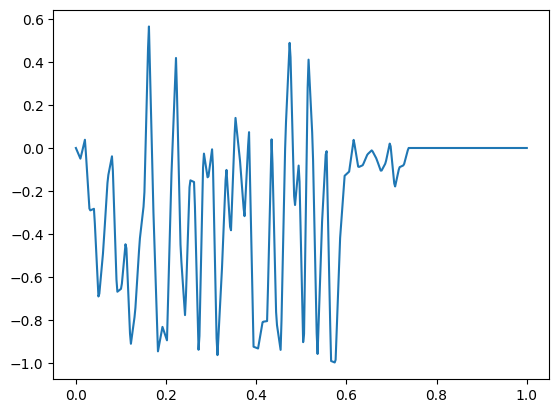

In [211]:
X_func[12000].plot()
y[12000]

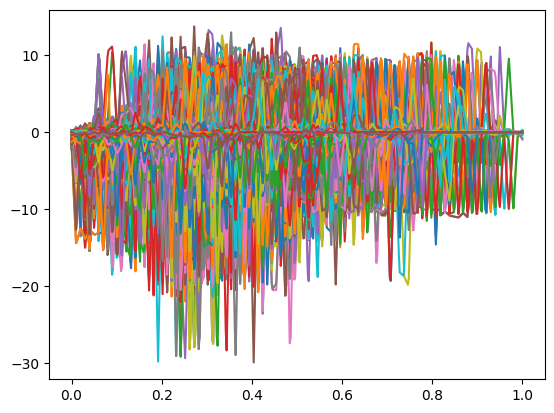

Error in callback <function flush_figures at 0x0000026E1C2DCD60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
X_func.data_matrix 

In [ ]:
# hacer analisis descriptivo de los datos